<a href="https://colab.research.google.com/github/preeti13456/RedditDetection/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install praw
import praw
import numpy as np
import pandas as pd
import datetime as dt
import time
import unicodedata
import re
import editdistance
import pickle
import sklearn.preprocessing 

# Sentiment Analysis
from textblob import TextBlob

# Statistical Testing
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve, auc, classification_report

# Class imbalance 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

# Plotting 
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,8]
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [54]:
df = pd.read_csv('/content/covid patient.csv',error_bad_lines=False)

In [55]:
df

,Date,7-day average,SDMA daily growth,TPR 7 day
0,17/11/2020,39564,-2.20%,4.00%
1,18/11/2020,39148,-1.10%,4.08%
2,19/11/2020,39376,0.60%,4.21%
3,20/11/2020,39615,0.60%,4.27%
4,21/11/2020,40130,1.30%,4.25%
5,22/11/2020,42091,4.90%,4.13%
6,23/11/2020,43352,3.00%,4.41%
7,24/11/2020,44176,1.90%,4.02%
8,25/11/2020,44080,-0.20%,3.86%
9,26/11/2020,43650,-1.00%,3.96%


In [56]:
df.dtypes

Date                 object
7-day average         int64
SDMA daily growth    object
TPR 7 day            object
dtype: object

In [57]:
train_df, test_df = train_test_split(df, test_size = 0.1)

In [58]:
train_df.head()

,Date,7-day average,SDMA daily growth,TPR 7 day
5,22/11/2020,42091,4.90%,4.13%
9,26/11/2020,43650,-1.00%,3.96%
6,23/11/2020,43352,3.00%,4.41%
8,25/11/2020,44080,-0.20%,3.86%
0,17/11/2020,39564,-2.20%,4.00%


In [59]:
X_train = train_df.iloc[:,5:]
y_train = train_df.iloc[:,0]

X_test = test_df.iloc[:,5:]
y_test = test_df.iloc[:,0]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9, 0), (9,), (1, 0), (1,))

In [60]:
#X_train.describe()
X_train.replace([np.inf,-np.inf],np.nan,inplace=True)
X_test.replace([np.inf,-np.inf],np.nan, inplace=True)

""
7


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2589: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Frequency')

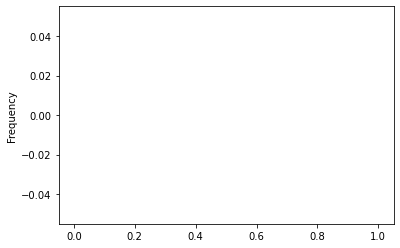

In [61]:
sns.distplot(X_train,kde=False)
plt.ylabel("Frequency")

In [62]:
train_eda = pd.concat([X_train,y_train],axis=1,join='outer')

train_eda.shape

(9, 1)

In [63]:
train_eda

,Date
5,22/11/2020
9,26/11/2020
6,23/11/2020
8,25/11/2020
0,17/11/2020
2,19/11/2020
4,21/11/2020
3,20/11/2020
1,18/11/2020


(-0.25, 0.5)

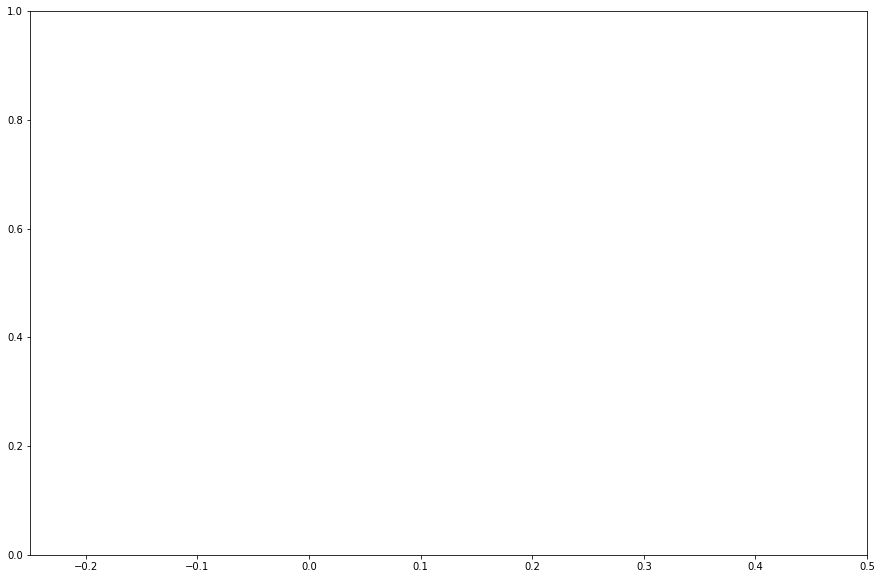

In [64]:
df_melt_score = pd.melt(train_eda,
                 id_vars = ['Date'],
                 var_name = 'Patient',
                 value_name = 'Covid_Fight')

df_melt_score['Date'] = df_melt_score['Date'].apply(lambda x: x.split(' Score')[0])

plt.figure(figsize=(15,10))
#g = sns.factorplot(x="Date", y="Date",
 #                  row="Result",
                   
  #                 )

plt.xlim(-0.25,0.5)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


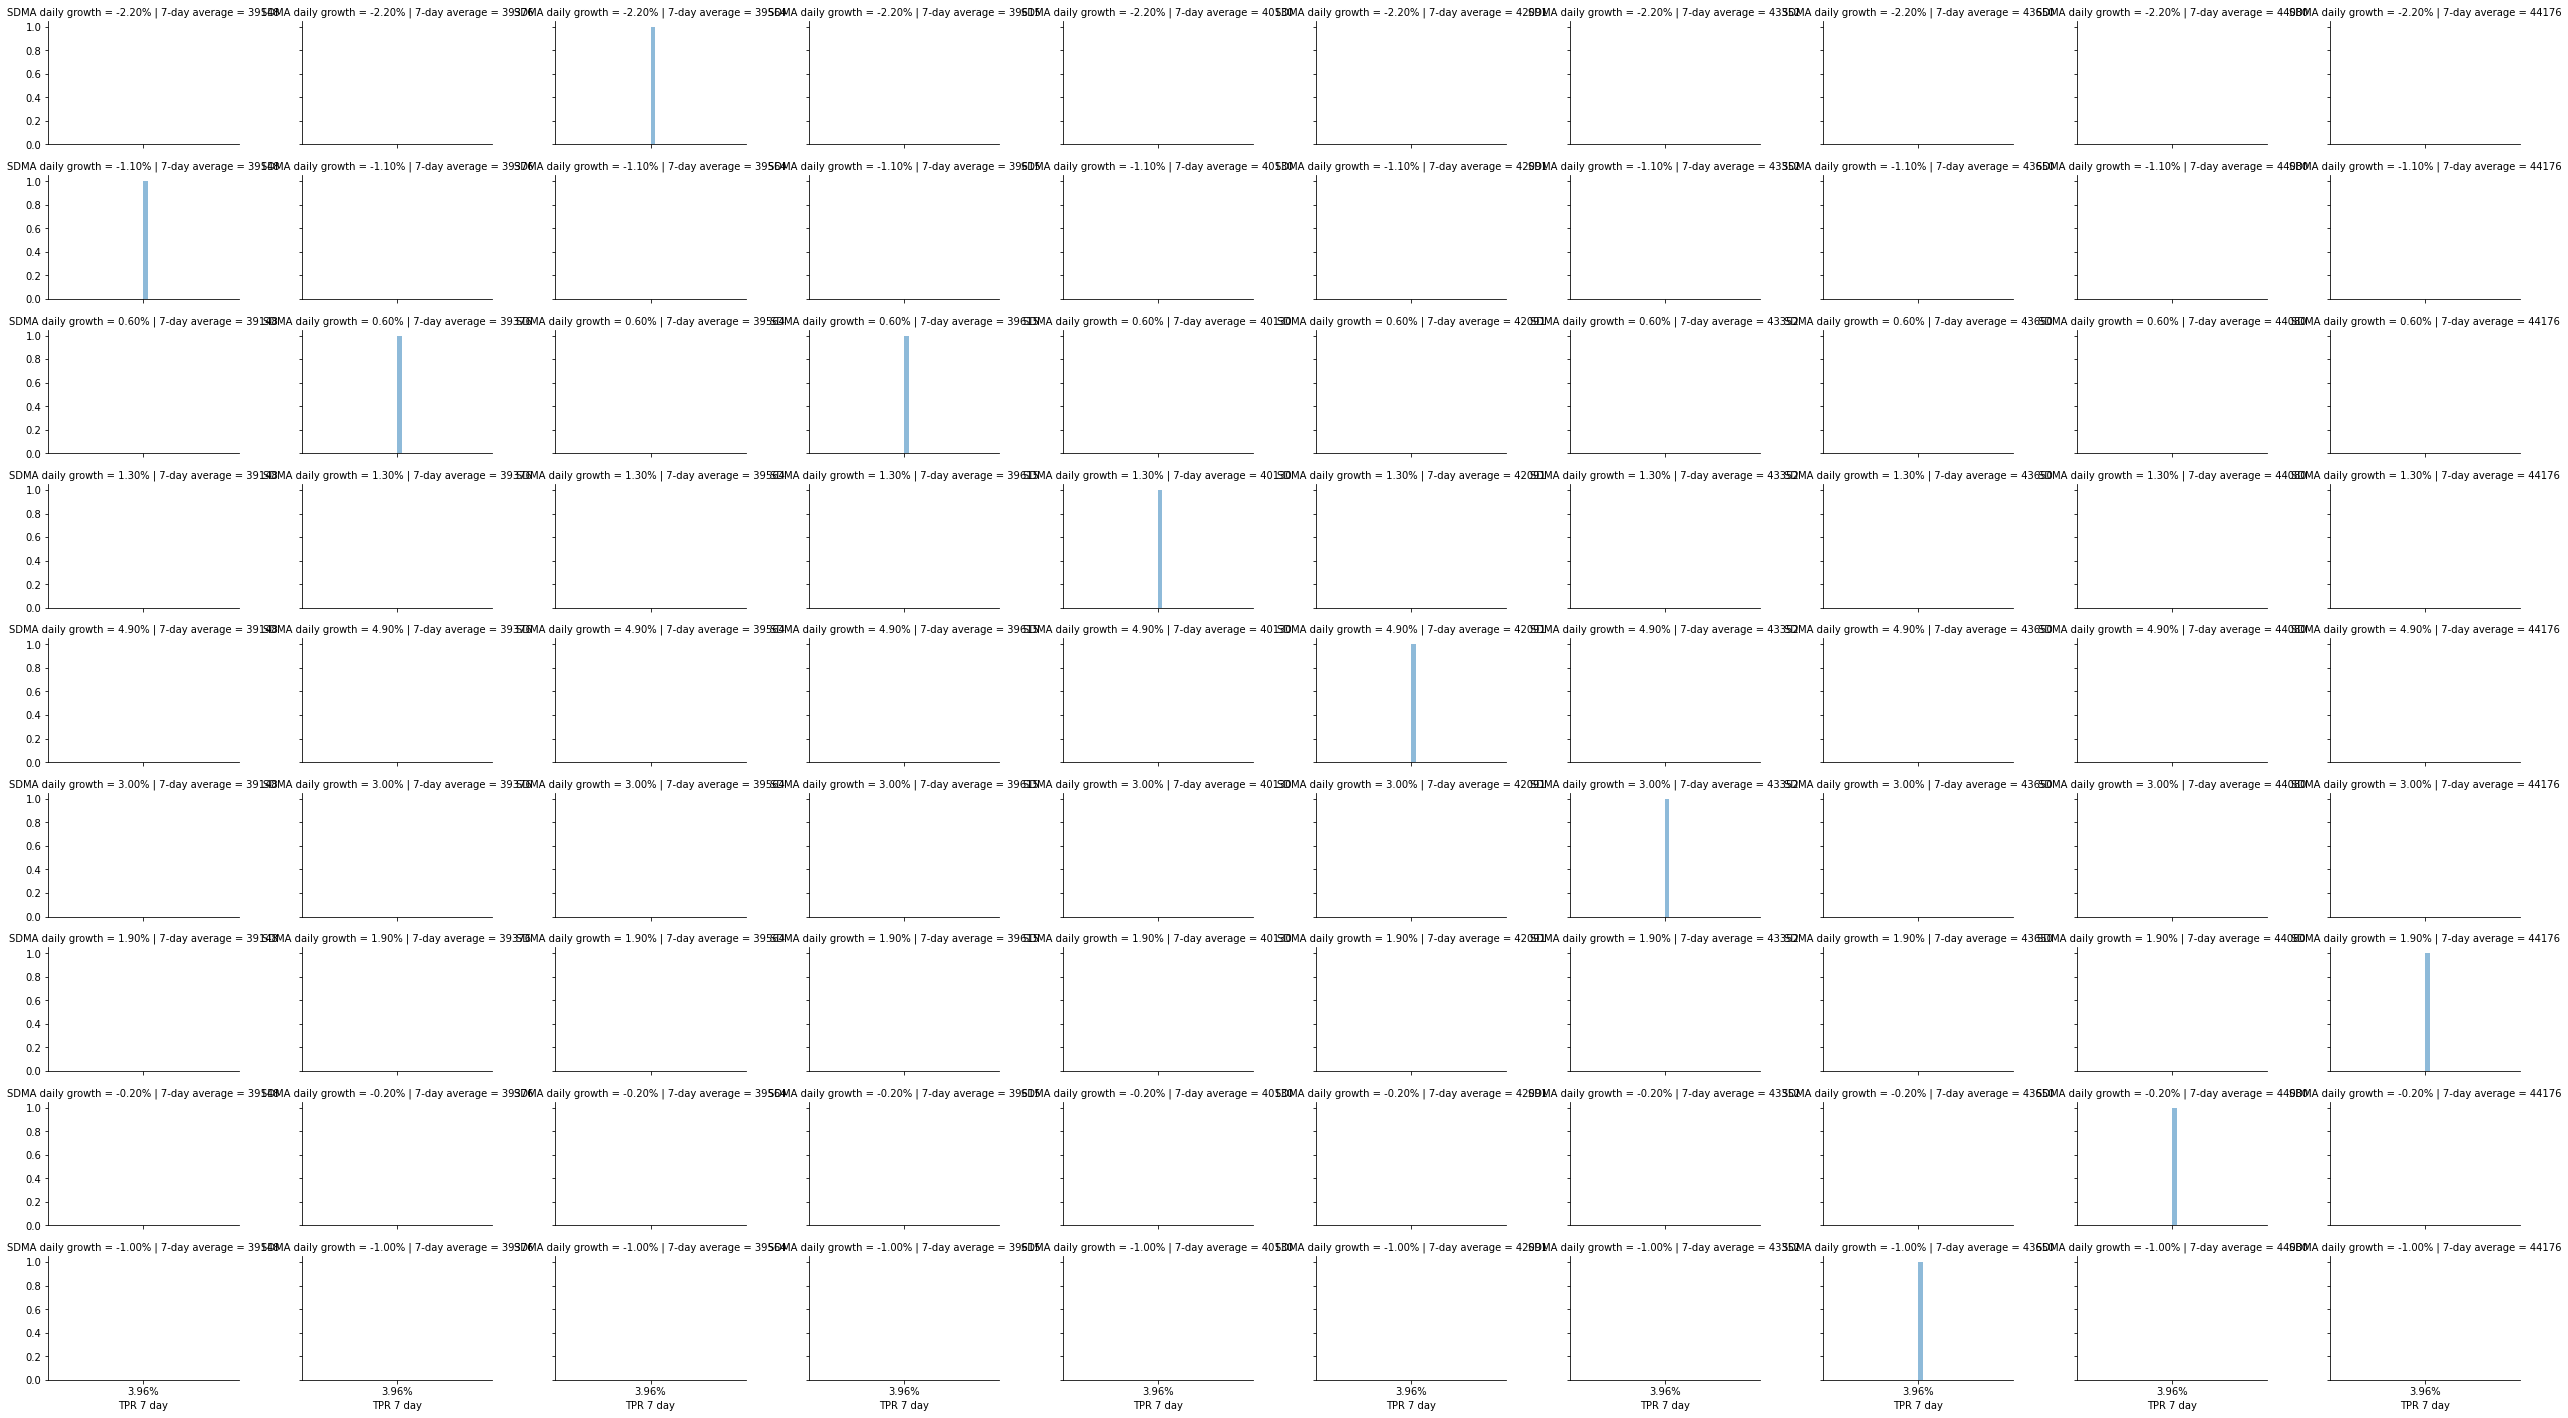

In [65]:
grid = sns.FacetGrid(df, col='7-day average', row='SDMA daily growth', size=2.2, aspect=1.6, xlim=(-1,1))
grid.map(plt.hist, 'TPR 7 day', alpha=.5, bins=20)
grid.add_legend();

In [66]:
def anova_test(df,flair_type):
    anova_df = df.loc[df['Date']==flair_type].dropna()
    mod = ols('7-day average',
                data=anova_df).fit()
    return(sm.stats.anova_lm(mod, typ=2))

In [ ]:
X_train.isnull().sum()

In [ ]:
from sklearn.impute import SimpleImputer

Ndim = 13

imr = SimpleImputer(missing_values='NaN', strategy='median')
impute_df_train = imr.fit_transform(np.array(X_train.iloc[:,:Ndim]))
#impute_df_test = imr.transform(np.array(X_test.iloc[:,:Ndim]))

X_train.iloc[:,:Ndim] = impute_df_train
X_test.iloc[:,:Ndim] = impute_df_test

In [79]:
f = open("cleaned_data.pckl", "wb")
pickle.dump(X_train,f)
pickle.dump(y_train,f)
pickle.dump(X_test,f)
pickle.dump(y_test,f)